In [31]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pickle
plt.style.use('ggplot')
%matplotlib inline

gc.collect()

train = pd.read_csv('train.csv')

# Dataset Review

## Description

PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

## Features

 - **step:** maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
 - **type:** CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
 - **amount:** amount of the transaction in local currency.
 - **nameOrig:** customer who started the transaction
 - **oldbalanceOrg:** initial balance before the transaction
 - **newbalanceOrig:** new balance after the transaction
 - **nameDest:** customer who is the recipient of the transaction
 - **oldbalanceDest:** initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
 - **newbalanceDest:** new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
 - **isFlaggedFraud:** The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.
 
## Outcome Variable
 
 - **isFraud:** 
  - This is the transactions made by the fraudulent agents inside the simulation. 
  - In this specific dataset the fraudulent behavior is defined as where the agent aims to profit by: 
      - (a) taking control or customers accounts and 
      - (b) emptying the funds by transferring to another account and 
      - (c) cashing out of the system 

## Approach Summary

We created a part rule-based, part machine learning based model to identify fraudulent transactions. 

The rule-based method labeled the following transaction types as fraudulent:

 1. Transfer transactions where the new balance destination and the old balance destination are 0.
 2. Cash out transactions where the amount cashed out is equal to the balance prior to the transaction. 

In addition to the creating rules based on the above criteria, we reccomend the bank implement a gradient boosted decision tree model to assess all other transactions for potential fraud.

If applied during the sample period, our approach would identify all fraudulent transactions from the sample period.

## Initial Questions

 - What payment types have the most fraudulent transactions?
 - Is there any daily fraud transaction pattern?
 - Is there any hourly pattern within a day?

## Section 1.0 - Initial Data Set Review

In [32]:
#shape and describe
print(train.shape, print(train.describe())) #over 6 million total trans

               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00

In [33]:
#head
train.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [34]:
#look at one fraud transaction
train[train['nameOrig'] == 'C1529008245']

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.0,0.0,1,0


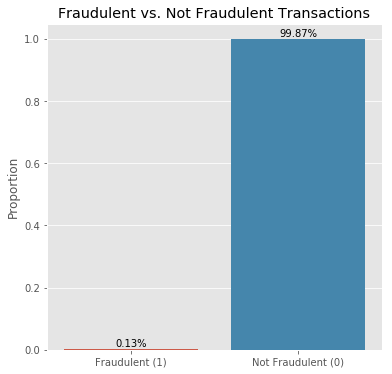

In [35]:
#Review the prevalence of fraud

plt.figure(figsize=(6,6))
#sns.set(font_scale=1.2)
mean = (train.isFraud.values == 1).mean()
ax = sns.barplot(['Fraudulent (1)', 'Not Fraudulent (0)'], [mean, 1-mean])
ax.set(ylabel='Proportion', title='Fraudulent vs. Not Fraudulent Transactions')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

In [36]:
train['isFraud'].value_counts() #8,213 are fraud; .13%

0    6354407
1       8213
Name: isFraud, dtype: int64

## Section 2.0 - Data Preparation

 - Create day and hour columns from step. 
 - Split into train and test (20 days train, 10 days test)

In [37]:
#create day column - divide step by 24 and round down to nearest integer
train['day'] = train['step'].transform(lambda x: x / 24).astype('int')
train['day'] = train['day'] + 1
train['hour'] = train['step'] - (24 * train['day'] - 24) + 1
print(train['day'].describe())

count    6.362620e+06
mean     1.050316e+01
std      5.922111e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.000000e+01
75%      1.400000e+01
max      3.100000e+01
Name: day, dtype: float64


In [38]:
#split data into training and holdout
#holdout - last 10 days
#train - first 20 days
holdout = train[(train['day'] > 19)]
train = train[(train['day'] <= 19)]
print(train.shape, train['isFraud'].mean() * 100, holdout.shape,  holdout['isFraud'].mean() * 100)

(6019698, 13) 0.08463879749449225 (342922, 13) 0.9092446678836587


## Section 3.1 - Exploratory Data Analysis

### Question

What payment types have the most fraudulent transactions?

### Procedure

Using our training set, we plotted a bar chart of each payment type and the count of fraudulent and non-fraudulent transactions.

### Conclusion

There were no fraudulent payments for payment types Cash In, Debit, or Payment.

The only observed fraudulent transactions were of type Cash out or Transfer.

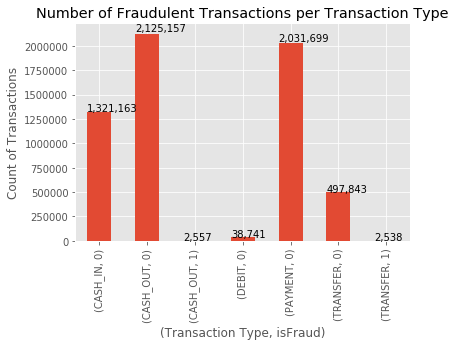

In [39]:
g = train.groupby(['type', 'isFraud']).size().plot(kind='bar')
g.set_title("Number of Fraudulent Transactions per Transaction Type")
g.set_xlabel("(Transaction Type, isFraud)")
g.set_ylabel("Count of Transactions")

mycolor = 'rgbkymc'

for p in g.patches:
    plt.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

## Section 3.2 - Exploratory Data Analysis

### Question

Are there any days with fraudulent activity is particularly high? Within these days, are there any times when fraud is more prevalent?

### Procedure

Using our training set, we plotted a bar and a line chart of the count of fraud transactions.

### Conclusion

Day two saw a comparatively large volume of fraudulent transactions, and a comaparatively low number of total transactions. We will review this day in more detail to see if we learn anything.

Looking more closely at the types of fraudulent transactions occurring during day 2, we were able to define two rules for identifying fraud transactions:

 1. Transfer transactions where the new balance destination and the old balance destination are 0.
 2. Cash out transactions where the amount cashed out is equal to the balance prior to the transaction. 
 
Due to the high incidence of fraud for these transaction types, we recommend the bank manually review all such transactions for potential fraud.

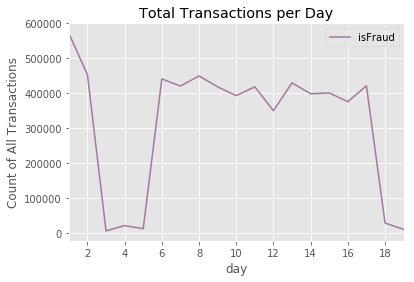

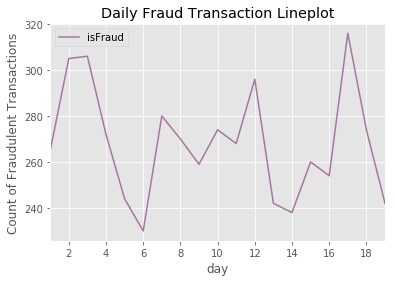

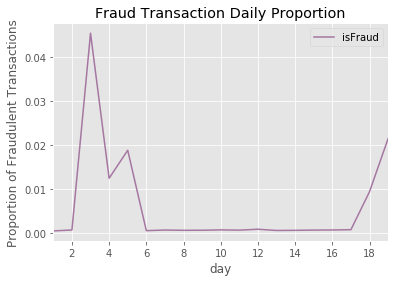

In [40]:
train[['day','isFraud']].groupby(['day'], as_index=True).count().plot(color='#a576a1')
plt.title('Total Transactions per Day');
plt.ylabel('Count of All Transactions');

#daily frauds
train[['day','isFraud']].groupby(['day'], as_index=True).sum().plot(color='#a576a1')
plt.title('Daily Fraud Transaction Lineplot');
plt.ylabel('Count of Fraudulent Transactions');

train[['day','isFraud']].groupby(['day'], as_index=True).mean().plot(color='#a576a1')
plt.title('Fraud Transaction Daily Proportion');
plt.ylabel('Proportion of Fraudulent Transactions');

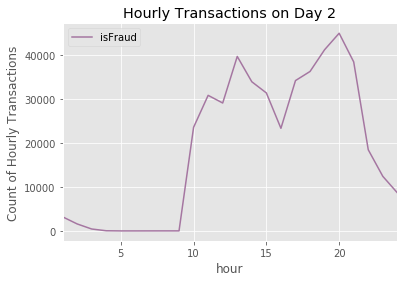

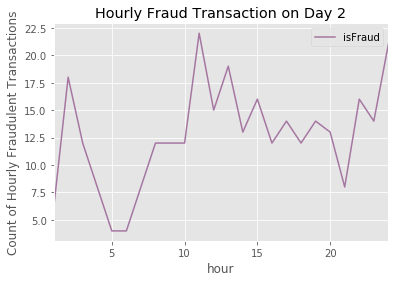

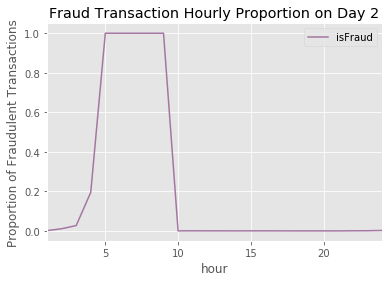

In [41]:
train.loc[train['day'] == 2, ['hour','isFraud']].groupby(['hour'], as_index=True).count().plot(color='#a576a1')
plt.title('Hourly Transactions on Day 2');
plt.ylabel('Count of Hourly Transactions');

#daily frauds
train.loc[train['day'] == 2, ['hour','isFraud']].groupby(['hour'], as_index=True).sum().plot(color='#a576a1')
plt.title('Hourly Fraud Transaction on Day 2');
plt.ylabel('Count of Hourly Fraudulent Transactions');

train.loc[train['day'] == 2, ['hour','isFraud']].groupby(['hour'], as_index=True).mean().plot(color='#a576a1')
plt.title('Fraud Transaction Hourly Proportion on Day 2');
plt.ylabel('Proportion of Fraudulent Transactions');

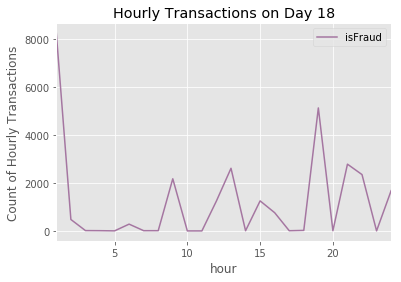

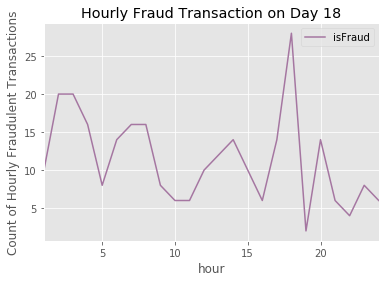

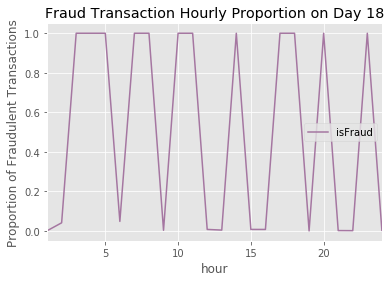

In [42]:
train.loc[train['day'] == 18, ['hour','isFraud']].groupby(['hour'], as_index=True).count().plot(color='#a576a1')
plt.title('Hourly Transactions on Day 18');
plt.ylabel('Count of Hourly Transactions');

#daily frauds
train.loc[train['day'] == 18, ['hour','isFraud']].groupby(['hour'], as_index=True).sum().plot(color='#a576a1')
plt.title('Hourly Fraud Transaction on Day 18');
plt.ylabel('Count of Hourly Fraudulent Transactions');

train.loc[train['day'] == 18, ['hour','isFraud']].groupby(['hour'], as_index=True).mean().plot(color='#a576a1')
plt.title('Fraud Transaction Hourly Proportion on Day 18');
plt.ylabel('Proportion of Fraudulent Transactions');

In [43]:
train[(train['day'] == 2) & (train['hour'] >= 5) & (train['hour'] < 10)].head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day,hour
576334,28,TRANSFER,3832058.34,C1279307827,3832058.34,0.0,C1124913173,0.00,0.00,1,0,2,5
576335,28,CASH_OUT,3832058.34,C426880249,3832058.34,0.0,C1566081912,531662.14,4363720.48,1,0,2,5
576336,28,TRANSFER,491517.77,C1029198062,491517.77,0.0,C1534111155,0.00,0.00,1,0,2,5
576337,28,CASH_OUT,491517.77,C1198658385,491517.77,0.0,C523126423,518777.34,1010295.11,1,0,2,5
576338,29,TRANSFER,340198.41,C491994230,340198.41,0.0,C772681684,0.00,0.00,1,0,2,6


In [44]:
train[(train['type'] == 'TRANSFER') & (train['newbalanceDest'] == 0) & (train['oldbalanceDest'] == 0)]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day,hour
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.0,1,0,1,2
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.00,C972765878,0.0,0.0,1,0,1,2
680,1,TRANSFER,20128.00,C137533655,20128.00,0.00,C1848415041,0.0,0.0,1,0,1,2
969,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.00,C431687661,0.0,0.0,1,0,1,2
1115,1,TRANSFER,35063.63,C1364127192,35063.63,0.00,C1136419747,0.0,0.0,1,0,1,2
1248,1,TRANSFER,271161.74,C1658487789,0.00,0.00,C1219161283,0.0,0.0,0,0,1,2
1869,1,TRANSFER,25071.46,C669700766,25071.46,0.00,C1384210339,0.0,0.0,1,0,1,2
2301,1,TRANSFER,235238.66,C1872047468,235238.66,0.00,C116289363,0.0,0.0,1,0,1,2
3059,2,TRANSFER,1096187.24,C1093223281,1096187.24,0.00,C2063275841,0.0,0.0,1,0,1,3
3162,2,TRANSFER,963532.14,C1440057381,963532.14,0.00,C268086000,0.0,0.0,1,0,1,3


In [45]:
transfer = train[(train['type'] == 'TRANSFER') & (train['newbalanceDest'] == 0) & (train['oldbalanceDest'] == 0)]
transfer['isFraud'].mean()

0.9594646271510516

In [46]:
train[(train['type'] == 'CASH_OUT') & (train['amount'] == train['oldbalanceOrg'])].head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day,hour
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00,1,0,1,2
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.0,0.00,1,0,1,2
681,1,CASH_OUT,20128.00,C1118430673,20128.00,0.0,C339924917,6268.0,12145.85,1,0,1,2
970,1,CASH_OUT,1277212.77,C467632528,1277212.77,0.0,C716083600,0.0,2444985.19,1,0,1,2
1116,1,CASH_OUT,35063.63,C1635772897,35063.63,0.0,C1983025922,31140.0,7550.03,1,0,1,2


In [47]:
cashout = train[(train['type'] == 'CASH_OUT') & (train['amount'] == train['oldbalanceOrg'])]
cashout['isFraud'].mean()

1.0

## Section 4.0 - Feature Engineering

Based on the Results of the above analysis, we created four types of new features:

1. Rule based feature to detect suspicious transactions
2. Time features (day and hour)
3. Dummifications of important categorical features (Transaction Type, Customer Type)
4. Ratio of Transaction Amout to Originator/Destination Balance values

In [48]:
#Feature Type 1 - detect - rule based fraud transaction identifier
train['detect'] = np.where(((train['type'] == 'TRANSFER') & \
                                      (train['newbalanceDest'] == 0) & \
                                      (train['oldbalanceDest'] == 0)) | \
                                      ((train['type'] == 'CASH_OUT') & \
                                      (train['amount'] == train['oldbalanceOrg'])), 1, 0)

#Feature Type 2 - Create day and hour field
train['day'] = train['step'].transform(lambda x: x / 24).astype('int')
train['day'] = train['day'] + 1
train['hour'] = train['step'] - (24 * train['day'] - 24) + 1

#Feature Type 3 - remove non numeric features by creating categories
#cash out indicator
#transfer indicator
#C Company indicator for originator and Destination
train['transfer'] = np.where(train['type'] == 'TRANSFER', 1, 0)
train['cashOut'] = np.where(train['type'] == 'CASH_OUT', 1, 0)
train['NO'] = train['nameOrig'].astype(str).str[0]
train['origC'] = np.where(train['NO'] == 'C', 1, 0)
train['ND'] = train['nameDest'].astype(str).str[0]
train['destC'] = np.where(train['ND'] == 'C', 1, 0)

#Feature Type 4 - Amount Ratios
train['AMNB0'] = train['amount'] / train['newbalanceOrig']
train['AMOBO'] = train['amount'] / train['oldbalanceOrg']
train['AMNBD'] = train['amount'] / train['newbalanceDest']
train['AMOBD'] = train['amount'] / train['oldbalanceDest']
train['NOBRD'] = train['newbalanceDest'] / train['oldbalanceDest']

#Drop non-numeric features
train.drop(['nameOrig', 'nameDest', 'NO', 'ND', 'type'], axis = 1, inplace = True)

In [49]:
#Save data for modeling
train.to_csv('train2.csv', index = False)